# ED.jl

In [ ]:
"""
This will be the module for all the ED routines.
"""
module ED

using SparseArrays

include("libED.jl")
include("libHam.jl")
include("libLA.jl")
include("libTest.jl")
include("libUtils.jl")
include("libEDComm.jl")
# include("libNewComm.jl")
# include("libNewComm2.jl")
# include("libNewComm3.jl")
# include("libNewComm4.jl")
# include("libNewComm5.jl")
include("libNewComm6.jl")

end

# libED.jl

Bitwise Operators
The following bitwise operators are supported on all primitive integer types:

Expression	Name
- `~x`	bitwise not
- `x & y`	bitwise and
- `x | y`	bitwise or
- `x ⊻ y`	bitwise xor (exclusive or)
- `x >>> y`	logical shift right
- `x >> y`	arithmetic shift right
    - For binary numbers it is a bitwise operation that shifts all of the bits of its operand;
- `x << y`	logical/arithmetic shift left

In [66]:
bitstring(2)

"0000000000000000000000000000000000000000000000000000000000000010"

In [94]:
for i in 1:5
    println( bitstring(bitcycle(8,i)) )
end

0000000000000000000000000000000000000000000000000000000000001000
0000000000000000000000000000000000000000000000000000000000000100
0000000000000000000000000000000000000000000000000000000000000010
0000000000000000000000000000000000000000000000000000000000000001
0000000000000000000000000000000000000000000000000000000000010000


In [93]:
for i in 1:5
    println( bitstring(bitcycle(4,i)) )
end

0000000000000000000000000000000000000000000000000000000000000100
0000000000000000000000000000000000000000000000000000000000000010
0000000000000000000000000000000000000000000000000000000000000001
0000000000000000000000000000000000000000000000000000000000001000
0000000000000000000000000000000000000000000000000000000000001000


In [96]:
findBasis(4,0,1)

2-element Vector{Int64}:
 3
 5

In [1]:
using SparseArrays


In [2]:
# This library will hold the ED functions.
# This code was based off of the helpful notes by Prof. Sandvik
# https://physics.bu.edu/~sandvik
# https://physics.bu.edu/~sandvik/perimeter/

# Flip the bits of integer a at bit sites i and j
function bitflip(a::Int64,i::Int64,j::Int64)::Int64
    # Note: 1<<i == 2^i
    # i & j must be different. Then just xor bits at indexes i & j
    return xor(a, 1<<i + 1<<j)
end

# Flip the bits of integer a at bit site i
function bitflip(a::Int64,i::Int64)::Int64
    # Flips the bit at position i in the binary representation of a
    return xor(a, 1<<i)
end

# get sigma_z at site i, does no "flipping"
function bitsign(a::Int64,i::Int64)::Int64
    # Returns "-1" if binary a at i is 1
    # Returns "1" if binary a at i is 0
    return (1-2*((a>>i)&1))
end

# sum the first L (least) bits of an Int64
function bitsum(x::Int64,L::Int64)::Int64
    # Self explanatory. Sums the first L bits & returns. 
    num ::Int64 = 0
    for i in 0:(L-1)
        num += (x>>i) & 1
    end
    return num
end

# Reverse the L rightmost bits of x
function bitreverse(x::Int64,L::Int64)::Int64
    # flips RL->LR, rightmost L bits in x
    # ex. flip x=3 b(011) by L=3 -> b(110) aka 6
    ans ::Int64= 0
    for i in 0:(L-1)
        ans += ((x>>i) & 1) << (L-1-i)
    end
    return ans
end

# cycle the bits to the "right" by one.
function bitcycle(x::Int64,L::Int64)::Int64
    # ???
    return (x<<1)&(2^L-1) + (x>>(L-1))
end


#=
Locate (the index of) integer x in an ordered list.. .
Julia probably has a better version of this..
I tested it, findfirst() sees to actually be slower.
=#
function locateState(x::Int64, list::Array{Int64,1})::Int64
    # Self-explanatory
    bmin = 1
    bmax = length(list)
    while bmin <=  bmax
        b = bmin+ floor(Int, (bmax - bmin)/2)
        if list[b]<x
            bmin = b +1
        elseif list[b]>x
            bmax = b -1
        else
            return b
        end
    end
    return -1
end


#=
This will find the representative states for a given
sub-block in the spin parity, mirror symmetry basis.

We specify mirror symmetry because in cases like (L even)
p = 0, m = 1, it will not be the same set of states as
p = 0, m = 0, as the latter have states like 0110,
1001, 0000 (for L = 4), that vanish in the former.
=#
function findBasis(L::Int64,p::Int64,m::Int64)
    # ??
    ans :: Array{Int64,1} = []
    if m == 0
        for a in 0:(2^L-1)
            pt ::Int64 = bitsum(a,L)%2
            bt ::Int64 = bitreverse(a,L)
            if p == pt && a<=bt # note the <=
                push!(ans,a)
            end
        end
    else
        for a in 0:(2^L-1)
            pt ::Int64 = bitsum(a,L)%2
            bt ::Int64 = bitreverse(a,L)
            if p == pt && a<bt # note the <
                push!(ans,a)
            end
        end
    end
    return ans
end


#=
Find periodicity of state.. just for inversion this
is simple, its either 1 or 2
(0110) -> R = 1, one mirror flip to return to itself
(0011) -> R = 2, two mirror flips to return to itself
=#
function findPeriod(x::Int64,L::Int64)::Int64
    # Self-explanatory
    y = bitreverse(x,L)
    if x != y
        return 2
    else
        return 1
    end
end


#=
Reverse bitstring->y, if y<x then
y is the rep. If x<y then x is the rep.
For sign flips returning 0,1 depending on if
x or y is returned
=#
function findRep(x::Int64,L::Int64)
    y = bitreverse(x,L)
    if y < x
        return y, 1
    else
        return x, 0
    end
end

findRep (generic function with 1 method)

# libLA.jl

In [3]:
#=
This module is where common functions that are
closer to this current project will go.
=#

using LinearAlgebra
using Printf

# Expects Hermitian matrix, orders from low to high
function diagonalize(mat)
    u,v = eigen(mat)
    u = real.(u)
    order = sortperm(u)
    u = u[order]
    v = v[:,order]
    return u,v
end

# finds value of Z_2 for a list of states
function pairities(L,vs)
    pairities = zeros(2^L)
    for n in 1:2^L
        pairities[n] = Z2(L,Array{Complex{Float64},1}(vs[:,n]))
    end
    return pairities
end

# Expects Hermitian matrix, orders from low to high
function diagonalize_vals(mat)
    u = eigvals(mat)
    u = real.(u)
    order = sortperm(u)
    u = u[order]
    return u
end


# creates propagator from eigenbasis
function propagator(u,v,phase)
    return v*Diagonal(exp.(phase.*u))*v'
end


# If you have data for different Ls, Jzs, gs
# then print it out with this function.
# its assuming a single float for each entry.
function printout(data,Ls,jzs,gs,message;scientific = false)
    println(message)
    for (Li,L) in enumerate(Ls)
        @printf("L=% 5d|",L)
        for k in 1:length(jzs)
            @printf("jz=% 7.2f|",jzs[k])
        end
        println("")
        for (gi,g) in enumerate(gs)
            @printf("g=% 5.2f|",g)
            for (jzi,jz) in enumerate(jzs)
                if scientific
                    @printf("% 10.2e|",data[Li,gi,jzi])
                else
                    @printf("% 10.2f|",data[Li,gi,jzi])
                end
            end
            println("")
        end
        println("")
    end
end


# If you have data for different Ls, gs, no jzs
# its assuming a single float for each entry.
function printout(data,Ls,gs,message;scientific = false)
    println(message)
    @printf("%7s|","")
    for k in 1:length(gs)
        @printf("g=% 8.2f|",gs[k])
    end
    println("")
    for (Li,L) in enumerate(Ls)
        @printf("L=% 5d|",L)
        # @printf("%8s","")
        for (gi,g) in enumerate(gs)
            if scientific
                @printf("% 10.2e|",data[Li,gi])
            else
                @printf("% 10.2f|",data[Li,gi])
            end
        end
        println("")
    end
end


#=
The wavefunction will be in the block-diagonal basis.
desired time using sparse matrices and KrylovKit.
[(p = 0,m = 0 sector), (p = 0, m = 1), (p = 1, m = 0),(p = 1, m = 1)]
=#
function TimeEvolve(L::Int64,Jx::Float64,Jz::Float64,mu::Float64,time::Float64,overlaps)
    newstate = []
    for p in 0:1, m in 0:1
        # get wavefunction in this block
        index = 2*p + m + 1
        state = overlaps[index]
        # if state has no weight in this sector, just
        # return zero (Krylov stuff will fail otherwise)
        if norm(state) > 0.0
            # create the sparse matrices
            hzz = Hzz(L,Jz,p,m)
            hxx = Hxx(L,Jx,p,m)
            hz = Hz(L,mu,p,m)
            h = hxx + hz + hzz
            tmp1 = exponentiate(h,-im*time,state)
            state[:] = tmp1[1]
        end
        push!(newstate,state)
    end
    return newstate
end


function TimeEvolve_simple(h,time,state)
    tmp = exponentiate(h,-im*time,state,verbosity = 1)
    return tmp[1]
end

TimeEvolve_simple (generic function with 1 method)

# libEDComm.jl

In [4]:
#=
This is where the ED commutator routines will go for now.
=#


comm_op_dot(L,op1,op2) =  1/(2^L)*tr(op1'*op2)
comm_get_b(L,op) = sqrt(comm_op_dot(L,op,op))
comm_get_comm(H,op) = H*op - op*H
comm_get_A(H,bn1,op1,op2) = comm_get_comm(H,op1) - bn1.*op2
comm_set_zero(val,threshold) = abs(val) < threshold ?  0.0 : val

function comm_check_Ops(L,ops)
    threshold = 1e-5
    @printf("n = %3d: ", length(ops))
    for i in 1:length(ops)
        tmp1 = abs(comm_op_dot(L,ops[i],ops[end]))^2
        @printf("%2.1e ",tmp1)
    end 
end 

function comm_get_bs(L,j,jz,g,gamma,threshold,steps;start = "x")
    #=
    This will calculate the b_n's in the usual ED 
    setup. This is full of round-off errors and numerical stability
    issues. Also, \sig_1^x breaks inversion and is 
    off-diagonal in parity.. At the moment it is not worth 
    optimizing this since we have another way of calculating these
    quantities.
    =#
    H = H_Delta(L,j,jz,g,gamma)
    if start == "y"
        Os = [im .*(sigZ(L,1)*sigX(L,1))]
    elseif start == "z"
        Os = [sigZ(L,1)]
    else 
        Os = [sigX(L,1)]
    end
    bs = []
    tmp = comm_get_comm(H,Os[1])
    # tmp = comm_set_zero.(tmp,threshold)
    println("")
    println("")
    println("")
    println(size(tmp))
    println("")
    println("")
    println("")
    tmpB = comm_get_b(L,tmp)
    if abs(tmpB) > threshold
        push!(Os,tmp ./tmpB)
        push!(bs,tmpB)
    else
        return
    end 

    for n in 1:steps-1
        tmpA = comm_get_comm(H,Os[end]) - bs[end]*Os[end-1]
        # tmpA = comm_set_zero.(tmpA,threshold)
        tmpB = comm_get_b(L,tmpA)
        if abs(tmpB)>threshold
            push!(Os,tmpA ./ tmpB)
            push!(bs,tmpB)
        else
            println("\n breaking out...\n")
            break
        end
        
        # reorthogonalize
        tmp_new = zeros(Complex{Float64},2^L,2^L)
        for m in length(Os)-1:-1:1
            tmp_new += Os[m] .*comm_op_dot(L,Os[m],Os[end])
        end 
        Os[end] -= tmp_new
        norm_tmp = sqrt.(comm_op_dot(L,Os[end],Os[end]))
        Os[end] = Os[end] ./ norm_tmp

        # comm_check_Ops(L,Os)
        @printf("b_%d:  %2.1e \r",n+1,abs(tmpB))
    end
    return bs, Os
end 


function comm_get_bs_cutoff(L,j,jz,g,gamma,threshold,steps,cutoff)
    #=
    This will calculate the b_n's in the usual ED 
    setup. This is full of round-off errors and numerical stability
    issues. Also, \sig_1^x breaks inversion and is 
    off-diagonal in parity.. At the moment it is not worth 
    optimizing this since we have another way of calculating these
    quantities.
    =#
    H = H_Delta(L,j,jz,g,gamma)
    Os = [sigX(L,1)]
    # Os = [im .*sigZ(L,1)*sigX(L,1)]
    bs = []
    tmp = comm_get_comm(H,Os[1])
    tmp = comm_set_zero.(tmp,threshold)
    tmpB = comm_get_b(L,tmp)
    if abs(tmpB) > threshold
        push!(Os,tmp ./tmpB)
        push!(bs,tmpB)
    else
        return bs, Os
    end 
    for n in 1:steps-1
        tmpA = comm_get_comm(H,Os[end]) - bs[end]*Os[end-1]
        tmpA = comm_set_zero.(tmpA,threshold)
        tmpB = comm_get_b(L,tmpA)
        if abs(tmpB)>threshold
            push!(Os,tmpA ./ tmpB)
            push!(bs,tmpB)
        else
            println("\n breaking out...\n")
            break
        end
        # reorthogonalize
        tmp_new = zeros(Complex{Float64},2^L,2^L)
        for m in length(Os)-1:-1:1
            tmp_new += Os[m] .*comm_op_dot(L,Os[m],Os[end])
        end 
        Os[end] -= tmp_new
        norm_tmp = sqrt.(comm_op_dot(L,Os[end],Os[end]))
        Os[end] = Os[end] ./ norm_tmp
        # comm_check_Ops(L,Os)
        @printf("b_%d:  %2.1e \r",n+1,tmpB)
        if bs[end] > cutoff
            break
        end
    end
    return bs, Os
end 

comm_get_bs_cutoff (generic function with 1 method)

# libUtils.jl

In [5]:
#=
This is where assorted functions go..
=#

using LinearAlgebra
using Dates

function get_uvs(L::Int64,g::Float64,jx::Float64,jz::Float64, gamma::Float64)
    #=
    This will find the eigenspectrum the smart way and 
    create the eigenvalue matrix U and the 
    eigenvector matrix V. Note that set L>=  L0 if you want to
    use binary basis for the computation for L<L0.
    =#
    us = []; vs = []
    if L >= 14 && L%2 == 0
        for (p1i, p) in enumerate(0:1), (mi,m) in enumerate(0:1)
            index = 2*p + m + 1
            u,v = eigen(H_Delta(L,jx,jz,g,gamma,p,m))
            us = vcat(us,u)
            vtmp = zeros(Complex{Float64},2^L,length(v[1,:]))
            for i in 1:length(v[1,:])
                tmp2 = block_to_binary(L,v[:,i],p,m)
                vtmp[:,i] = tmp2
            end
            if length(vs) == 0
                vs = vtmp
            else
                vs = hcat(vs,vtmp)
            end
        end
    else
        us,vs = eigen(H_Delta(L,jx,jz,g,gamma))
    end
    return us, vs
end


function get_Ainf(L::Int64,g::Float64,jx::Float64,jz::Float64, 
        gamma::Float64,times::AbstractArray)
    #=
    This is partially optimized.
    =#
    ainfs = zeros(Complex{Float64}, length(times))
    sigx = Complex{Float64}.(sigX(L,1))
    us,vs = get_uvs(L,g,jx,jz,gamma)
    sigxV = vs'*sigx*vs
    for ti in 1:length(times)
        print("ed: ti = $ti\r")
        U = Diagonal(exp.(-im*times[ti].*us))
        ainfs[ti] = 1/(2^L)*tr(U'*sigxV*U*sigxV)
    end
    return real.(ainfs)
end

function get_Ainf_Edge_mode(L::Int64,g::Float64,jx::Float64,
        jz::Float64, gamma::Float64,times::AbstractArray,
                coeffs::Array{Float64}, Ops)
    #=
    same as get_Ainf, but now try to use edge mode as starting point
    =#
    ainfs = zeros(Complex{Float64},length(times))
    #this will hold the overlaps with the krylov basis
    ainfs2 = zeros(Complex{Float64},length(Ops),length(times))
    # this will hold the autocorrelations of the krylov basis
    ainfs3 = zeros(Complex{Float64},length(Ops),length(times))

    edgemode = zeros(2^L,2^L)
    for (ci,coeff) in enumerate(coeffs)
        edgemode += Ops[ci].*coeff
    end

    sigx = sigX(L,1)
    us,vs = get_uvs(L,g,jx,jz,gamma)
    edge_time = vs'*edgemode*vs

    Ops2 = []
    for i in 1:length(Ops)
        push!(Ops2,vs'*Ops[i]*vs)
        # just add a dagger in trace below..
        # if i%2 == 0
        #     # add an imaginary factor to make these 
        #     # operators hermitian..
        #     push!(Ops2,im .* vs'*Ops[i]*vs)
        # else
        #     push!(Ops2,vs'*Ops[i]*vs)
        # end
    end

    for ti in 1:length(times)
        print("ed: ti = $ti\r")
        U = Diagonal(exp.(-im*times[ti].*us))
        ainfs[ti] = 1/(2^L)*tr(U'*edge_time*U*edge_time)
        for i in 1:length(Ops)
            ainfs2[i,ti] = 1/(2^L)*tr(U'*edge_time'*U*Ops2[i])
            ainfs3[i,ti] = 1/(2^L)*tr(U'*Ops2[i]'*U*Ops2[i])
        end
    end
    return real.(ainfs), real.(ainfs2), real.(ainfs3)
end



function get_L_ainf(M,times)
    u,v = eigen(M)
    v1 = v[1,:]
    v1c = conj.(v1)
    ainf = zeros(length(times))
    for (ti,time) in enumerate(times)
        print("time = $ti\r")
        ainf[ti] = real(transpose(v1)*Diagonal(exp.(im .* u .* time))*v1c)
    end 
    return ainf
end 

function make_M(bs)
    len = length(bs)+1
    M = zeros(len,len)
    for (bi,b) in enumerate(bs)
        M[bi,bi+1] = b
        M[bi+1,bi] = b
    end 
    return M
end


function make_M2(bs)
    len = length(bs)+1
    M = zeros(len,len)
    for (bi,b) in enumerate(bs)
        M[bi,bi+1] = -b
        M[bi+1,bi] =  b
    end 
    return M
end


function make_test_bs(L,alpha,delta,offset)
    bs = [offset + n*alpha + (1 + (-1)^n)/2*delta for n in 1:L]
    return bs
end


function make_test_bs2(L,alpha,delta,offset)
    bs = [offset + n*alpha + (1 + (-1)^n)/2*(delta/n) for n in 1:L]
    return bs
end



function make_my_edge_mode(bs)
    coeffs = []
    errors = []
    norms = []
    if length(bs)%2 == 1
        ratios = bs[1:2:end-1]./bs[2:2:end-1]
    else
        ratios = bs[1:2:end]./bs[2:2:end]
    end
    for n in 1:length(ratios)
        tmp = (-1)^(n+1)
        for m in 1:n-1
            tmp = tmp*ratios[m]
        end
        push!(coeffs,tmp)
        push!(errors,tmp*bs[2*n-1])
        push!(norms,sqrt(coeffs'*coeffs))
    end 
    return coeffs,errors,norms
end


function make_my_edge_mode2(bs)
    coeffs = []
    errors = []
    norms = []
    if length(bs)%2 == 1
        ratios = bs[1:2:end-1]./bs[2:2:end-1]
    else
        ratios = bs[1:2:end]./bs[2:2:end]
    end
    for n in 1:length(ratios)
        tmp = 1
        for m in 1:n-1
            tmp = tmp*ratios[m]
        end
        push!(coeffs,tmp)
        push!(errors,tmp*bs[2*n-1])
        push!(norms,sqrt(coeffs'*coeffs))
    end 
    return coeffs,errors,norms
end


function get_lifetime(times,data,cutoff = 0.1,window = 10)
    lifetime = 0
    for (ti,time) in enumerate(times[1:end-window])
        if 1/window*sum((data[ti:ti+window]))<cutoff # && time > 20
            lifetime = time
            break
        end
    end
    return lifetime
end


function get_fit(xs,ys)
    N1 = length(xs)
    avgX = sum(xs)/N1
    avgY = sum(ys)/N1
    slope = (xs'*ys - avgX*avgY*N1)/(xs'*xs - avgX^2*N1)
    inter = (xs'*ys - slope*(xs'*xs))/(avgX*N1)
    return slope, inter

end


function get_bn_fit(bs)
    xs = 1:length(bs)
    y1 = bs[1:2:end]
    x1 = xs[1:2:end]
    y2 = bs[2:2:end]
    x2 = xs[2:2:end]
    alpha_1,alpha0_1 = get_fit(x1,y1)
    alpha_2,alpha0_2 = get_fit(x2,y2)

    alpha =  (alpha_1 + alpha_2)/2
    delta = alpha0_2 - alpha0_1
    offset = alpha0_1
    return alpha, delta, offset
end



function find_domains(bs)
    #=
    This will find the positions where 
    staggering runs into an error.
    assumes the correct pattern is..
    down up down up down up...
    =#
    grow_shrink = []
    # values = []
    for bi in 1:2:length(bs)-1
        tmp = bs[bi]/bs[bi+1]
        if tmp>1.0
            push!(grow_shrink,1.0)
            push!(grow_shrink,1.0)
        else 
            push!(grow_shrink,-1.0)
            push!(grow_shrink,-1.0)
        end
    end
    return grow_shrink
end


function get_Ayy_inf(L::Int64,g::Float64,jx::Float64,
        jz::Float64, gamma::Float64,times::AbstractArray)
    #=
    Unoptimized autocorrelation for y1-y1
    =#
    ainfs = zeros(Complex{Float64}, length(times))
    sigx = sigX(L,1)
    sigz = sigZ(L,1)
    sigy = im.*(sigz*sigx)
    us,vs = eigen(H_Delta(L,jx,jz,g,gamma))
    sigyV = vs'*sigy*vs
    for ti in 1:length(times)
        print("ed: ti = $ti\r")
        U = Diagonal(exp.(-im*times[ti].*us))
        ainfs[ti] = 1/(2^L)*tr(U'*sigyV*U*sigyV)
    end
    return real.(ainfs)
end


function get_Azz_inf(L::Int64,g::Float64,jx::Float64,
        jz::Float64, gamma::Float64,times::AbstractArray)
    #=
    Unoptimized autocorrelation for z1-z1
    =#
    ainfs = zeros(Complex{Float64}, length(times))
    sigz = sigZ(L,1)
    us,vs = eigen(H_Delta(L,jx,jz,g,gamma))
    sigzV = vs'*sigz*vs
    for ti in 1:length(times)
        print("ed: ti = $ti\r")
        U = Diagonal(exp.(-im*times[ti].*us))
        ainfs[ti] = 1/(2^L)*tr(U'*sigzV*U*sigzV)
    end
    return real.(ainfs)
end


function get_Ainf_phase_floquet(L::Int64,
                                g::Float64,
                                jx::Float64,
                                jz::Float64,
                                gamma::Float64,
                                times::AbstractArray)
    #=
    =#
    ainfs = zeros(Complex{Float64}, length(times))
    sigz = sigZ(L,1)
    us,vs = eigen(H_Delta(L,jx,jz,g,gamma))
    sigzV = vs'*sigz*vs
    for ti in 1:length(times)
        print("ed: ti = $ti\r")
        U = Diagonal(exp.(-im*times[ti].*us))
        ainfs[ti] = 1/(2^L)*tr(U'*sigzV*U*sigzV)
    end
    return real.(ainfs)
end


function get_spectrum(L::Int64,g::Float64,jx::Float64,
        jz::Float64, gamma::Float64;outfile = "tmp_out.txt")
    #=
    This is partially optimized.
    THIS FUNCTION APPEARS TO BE NOT NEEDED...
    =#
    us = []; vs = []
    open(outfile,"a") do file
        write(file,"starting ED calculation\n")
    end

    if L >= 4 && L%2 == 0
        for (p1i, p) in enumerate(0:1), (mi,m) in enumerate(0:1)
            open(outfile,"a") do file
                write(file,"L = $(L), g = $(g), jz = $(jz),\
                    gamma = $(gamma), p = $(p), m = $(m), time = $(Dates.now())\n")
            end
            index = 2*p + m + 1
            u,v = eigen(H_Delta(L,jx,jz,g,gamma,p,m))
            us = vcat(us,u)
            vtmp = zeros(Complex{Float64},2^L,length(v[1,:]))
            for i in 1:length(v[1,:])
                tmp2 = block_to_binary(L,v[:,i],p,m)
                vtmp[:,i] = tmp2
            end
            if length(vs) == 0
                vs = vtmp
            else
                vs = hcat(vs,vtmp)
            end
        end
    else
        us,vs = eigen(H_Delta(L,jx,jz,g,gamma))
    end
    return (us,vs)
end

LoadError: syntax: invalid escape sequence

# libTest.jl

In [6]:
# This function returns the Hamiltonian for
# L = 4, written out explicitly.
# alpha is for the boundary condition
function smallH(Jx,g,Jz,alpha = 0.0)
    hxx = Jx.*[
        0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0;
        0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0;
        0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0;
        1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0;
        0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0;
        1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0;
        0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0;
        0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0;
        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0;
        1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0;
        0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0;
        0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0;
        0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0]
    hz = g .* [
        4.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  2.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  2.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  2.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  -2.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  2.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  -2.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  -2.0   0.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0  -2.0   0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   0.0  -4.0]
    hzz = Jz .* [
        3.0  0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  1.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0  -1.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  1.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0  -1.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0  -3.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0  -1.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0   0.0  1.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0   0.0  0.0  1.0   0.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0  -1.0   0.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0  -3.0   0.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0  -1.0  0.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  1.0   0.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0  -1.0  0.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  1.0  0.0;
        0.0  0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0  3.0]
    hxxP = alpha*Jx .*[
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0;
        0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0;
        1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0;
        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0]
    hzzP = alpha*Jz .*[
        1.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0  -1.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  1.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0  -1.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  1.0   0.0  0.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0  -1.0  0.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  1.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  0.0  -1.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  -1.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  1.0   0.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0  -1.0  0.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  1.0   0.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  0.0  -1.0  0.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  0.0   0.0  1.0   0.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0  -1.0  0.0;
        0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  1.0]
    return hxx + hz + hzz + hxxP + hzzP
end

smallH (generic function with 2 methods)

# libHam.jl

In [7]:
#=
Quantum spin chain functions for ED.
This is for open boundary conditions.
Block diagonalization takes advantage of spin parity and
inversion symmetry.

This code was based off of the helpful notes by Prof. Sandvik
https://physics.bu.edu/~sandvik
https://physics.bu.edu/~sandvik/perimeter/

"binary" is the "simple" basis (bit basis), not the
block-diagonalized basis (p,m basis)
p = 0,1 and m = 0,1
=#

# binary basis: \sigma_i^x \sigma_{i+1}^x
function Hxx(L::Int64, Jx::Float64)
    Hxx = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-2)
            j = i+1
            b = bitflip(a,i,j)
            Hxx[b+1,a+1] += Jx
        end
    end
    return Hxx
end

# sparse binary basis: \sigma_i^x \sigma_{i+1}^x
function HxxSP(L::Int64, Jx::Float64)
    Hxx = spzeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-2)
            j = i+1
            b = bitflip(a,i,j)
            Hxx[b+1,a+1] += Jx
        end
    end
    return Hxx
end

# binary basis \sigma_i^y \sigma_{i+1}^y
function Hyy(L::Int64,Jy::Float64)
    Hyy = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-2)
            j = i+1
            b = bitflip(a,i,j)
            coeff = Jy*bitsign(a,i)*bitsign(a,j)
            # Hyy[b+1,a+1] += coeff
            Hyy[b+1,a+1] -= coeff
        end
    end
    return Hyy
end

# sparse binary basis \sigma_i^y \sigma_{i+1}^y
function HyySP(L::Int64,Jy::Float64)
    Hyy = spzeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-2)
            j = i+1
            b = bitflip(a,i,j)
            coeff = Jy*bitsign(a,i)*bitsign(a,j)
            # Hyy[b+1,a+1] += coeff
            Hyy[b+1,a+1] -= coeff
        end
    end
    return Hyy
end


# block basis: \sigma_i^x \sigma_{i+1}^x
function Hxx(L::Int64,Jx::Float64,p::Int64,m::Int64)
    ref_states = findBasis(L,p,m)
    Hxx = zeros(Complex{Float64},length(ref_states),length(ref_states))
    for (n,a) in enumerate(ref_states)
        Ra = findPeriod(a,L)
        for i in 0:(L-2)
            b = bitflip(a,i,i+1)
            Rb = findPeriod(b,L)
            c,l = findRep(b,L)
            k = locateState(c,ref_states)
            if k>0
                Hxx[k,n] += Jx*(-1)^(l*m)*sqrt(Ra/Rb)
            end
        end
    end
    return Hxx
end

# block basis: \sigma_i^x \sigma_{i+1}^x, SPARSE
function HxxSP(L::Int64,Jx::Float64,p::Int64,m::Int64)
    ref_states = findBasis(L,p,m)
    Hxx = spzeros(Complex{Float64},length(ref_states),length(ref_states))
    for (n,a) in enumerate(ref_states)
        Ra = findPeriod(a,L)
        for i in 0:(L-2)
            b = bitflip(a,i,i+1)
            Rb = findPeriod(b,L)
            c,l = findRep(b,L)
            k = locateState(c,ref_states)
            if k>0
                Hxx[k,n] += Jx*(-1)^(l*m)*sqrt(Ra/Rb)
            end
        end
    end
    return Hxx
end


# block basis \sigma_i^y \sigma_{i+1}^y
function Hyy(L::Int64,Jy::Float64,p::Int64,m::Int64)
    ref_states = findBasis(L,p,m)
    Hyy = zeros(Complex{Float64},length(ref_states),length(ref_states))
    for (n,a) in enumerate(ref_states)
        Ra = findPeriod(a,L)
        for i in 0:(L-2)
            b = bitflip(a,i,i+1)
            Rb = findPeriod(b,L)
            c,l = findRep(b,L)
            k = locateState(c,ref_states)
            coeff = Jy*bitsign(a,i)*bitsign(a,i+1)
            if k>0
                # Hyy[k,n] += (-1)^(l*m)*sqrt(Ra/Rb)*coeff
                Hyy[k,n] -= (-1)^(l*m)*sqrt(Ra/Rb)*coeff
            end
        end
    end
    return Hyy
end

# block basis \sigma_i^y \sigma_{i+1}^y
function HyySP(L::Int64,Jy::Float64,p::Int64,m::Int64)
    ref_states = findBasis(L,p,m)
    Hyy = spzeros(Complex{Float64},length(ref_states),length(ref_states))
    for (n,a) in enumerate(ref_states)
        Ra = findPeriod(a,L)
        for i in 0:(L-2)
            b = bitflip(a,i,i+1)
            Rb = findPeriod(b,L)
            c,l = findRep(b,L)
            k = locateState(c,ref_states)
            coeff = Jy*bitsign(a,i)*bitsign(a,i+1)
            if k>0
                # Hyy[k,n] += (-1)^(l*m)*sqrt(Ra/Rb)*coeff
                Hyy[k,n] -= (-1)^(l*m)*sqrt(Ra/Rb)*coeff
            end
        end
    end
    return Hyy
end



# periodic boundary conditions, binary basis
function HxxP(L::Int64, Jx::Float64)
    pbc_xx = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        b = bitflip(a,L-1,0)
        pbc_xx[b+1,a+1] += Jx
    end
    return Hxx(L,Jx) + pbc_xx
end


# binary basis: \sigma_i^z \sigma_{i+1}^z
function Hzz(L::Int64, Jz::Float64)
    Hzz = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-2)
            Hzz[a+1,a+1] += Jz*bitsign(a,i)*bitsign(a,i+1)
        end
    end
    return Hzz
end

# binary basis: \sigma_i^z \sigma_{i+1}^z
function HzzSP(L::Int64, Jz::Float64)
    Hzz = spzeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-2)
            Hzz[a+1,a+1] += Jz*bitsign(a,i)*bitsign(a,i+1)
        end
    end
    return Hzz
end


# block basis: \sigma_i^z \sigma_{i+1}^z
function Hzz(L::Int64,Jz::Float64,p::Int64,m::Int64)
    ref_states = findBasis(L,p,m)
    Hzz = zeros(Complex{Float64},length(ref_states),length(ref_states))
    for (n,a) in enumerate(ref_states)
        for i in 0:(L-2)
            Hzz[n,n] += Jz*bitsign(a,i)*bitsign(a,i+1)
        end
    end
    return Hzz
end

# block basis: \sigma_i^z \sigma_{i+1}^z
function HzzSP(L::Int64,Jz::Float64,p::Int64,m::Int64)
    ref_states = findBasis(L,p,m)
    Hzz = spzeros(Complex{Float64},length(ref_states),length(ref_states))
    for (n,a) in enumerate(ref_states)
        for i in 0:(L-2)
            Hzz[n,n] += Jz*bitsign(a,i)*bitsign(a,i+1)
        end
    end
    return Hzz
end


# periodic boundary conditions, binary basis
function HzzP(L::Int64, Jz::Float64)
    pbc_zz = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        pbc_zz[a+1,a+1] += Jz*bitsign(a,L-1)*bitsign(a,0)
    end
    return Hzz(L,Jz) + pbc_zz
end


# binary basis: \sigma_i^z
function Hz(L::Int64, g::Float64)
    Hz = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-1)
            Hz[a+1,a+1] += g*bitsign(a,i)
        end
    end
    return Hz
end


# binary basis: \sigma_i^z
function sigZ(L::Int64, i::Int64)
    sigZ = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        sigZ[a+1,a+1] += bitsign(a,i-1)
    end
    return sigZ
end


# binary basis: \sigma_i^z
function HzSP(L::Int64, g::Float64)
    Hz = spzeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-1)
            Hz[a+1,a+1] += g*bitsign(a,i)
        end
    end
    return Hz
end

# block basis: \sigma_i^z
function Hz(L::Int64,mu::Float64,p::Int64,m::Int64)
    ref_states = findBasis(L,p,m)
    Hz = zeros(Complex{Float64},length(ref_states),length(ref_states))
    for (n,a) in enumerate(ref_states)
        for i in 0:(L-1)
            Hz[n,n] += mu*bitsign(a,i)
        end
    end
    return Hz
end

# block basis: \sigma_i^z
function HzSP(L::Int64,mu::Float64,p::Int64,m::Int64)
    ref_states = findBasis(L,p,m)
    Hz = spzeros(Complex{Float64},length(ref_states),length(ref_states))
    for (n,a) in enumerate(ref_states)
        for i in 0:(L-1)
            Hz[n,n] += mu*bitsign(a,i)
        end
    end
    return Hz
end


# binary basis: \sigma_i^z
function Hz_non_const(L::Int64, gs::Array{Float64})
    Hz = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-1)
            Hz[a+1,a+1] += gs[i+1]*bitsign(a,i)
        end
    end
    return Hz
end


# binary basis: Hz + Hxx + Hzz
function H(L::Int64,Jx::Float64,Jz::Float64,g::Float64)
    hzz = Hzz(L,Jz)
    hxx = Hxx(L,Jx)
    hz = Hz(L,g)
    return hxx + hz + hzz
end

# binary basis: Hz + Hxx + Hzz
function H_SP(L::Int64,Jx::Float64,Jz::Float64,g::Float64)
    hzz = HzzSP(L,Jz)
    hxx = HxxSP(L,Jx)
    hz = HzSP(L,g)
    return hxx + hz + hzz
end


# binary basis: Hz + Hxx + Hzz
function H_Delta(L::Int64, Jx::Float64, Jz::Float64, g::Float64, gamma::Float64)
    hzz = Hzz(L,Jz)
    hxx = Hxx(L,Jx*(1+gamma)/2)
    hyy = Hyy(L,Jx*(1-gamma)/2)
    hz = Hz(L,g)
    return hxx + hyy + hz + hzz
end


# binary basis: Hz + Hxx + Hzz
function H_Delta_non_const(L::Int64, Jx::Float64, Jz::Float64, 
        gs::Array{Float64}, gamma::Float64)
    hzz = Hzz(L,Jz)
    hxx = Hxx(L,Jx*(1+gamma)/2)
    hyy = Hyy(L,Jx*(1-gamma)/2)
    hz = Hz_non_const(L,gs)
    return hxx + hyy + hz + hzz
end


# binary basis: Hz + Hxx + Hzz
function H_Delta_SP(L::Int64, Jx::Float64, Jz::Float64, g::Float64, gamma::Float64)
    hzz = HzzSP(L,Jz)
    hxx = HxxSP(L,Jx*(1+gamma)/2)
    hyy = HyySP(L,Jx*(1-gamma)/2)
    hz = HzSP(L,g)
    return hxx + hyy + hz + hzz
end


# block basis: Hz + Hxx + Hzz
function H_Delta(L::Int64, Jx::Float64, Jz::Float64, g::Float64, gamma::Float64,
                 p::Int64, m::Int64)
    hzz = Hzz(L,Jz,p,m)
    hxx = Hxx(L,Jx*(1+gamma)/2,p,m)
    hyy = Hyy(L,Jx*(1-gamma)/2,p,m)
    hz = Hz(L,g,p,m)
    return hxx + hyy + hz + hzz
end

# block basis: Hz + Hxx + Hzz
function H_Delta_SP(L::Int64, Jx::Float64, Jz::Float64, g::Float64, gamma::Float64,
                 p::Int64, m::Int64)
    hzz = HzzSP(L,Jz,p,m)
    hxx = HxxSP(L,Jx*(1+gamma)/2,p,m)
    hyy = HyySP(L,Jx*(1-gamma)/2,p,m)
    hz = HzSP(L,g,p,m)
    return hxx + hyy + hz + hzz
end

# block basis: Hz + Hzz + Hxx
function H(L::Int64,Jx::Float64,Jz::Float64,g::Float64,p::Int64,m::Int64)
    hzz = Hzz(L,Jz,p,m)
    hxx = Hxx(L,Jx,p,m)
    hz = Hz(L,g,p,m)
    return hzz + hxx + hz
end


# periodic boundary conditions binary basis: Hz + Hxx + Hzz
function HP(L::Int64,Jx::Float64,Jz::Float64,g::Float64)
    hzz = HzzP(L,Jz)
    hxx = HxxP(L,Jx)
    hz = Hz(L,g)
    return hxx + hz + hzz
end

# binary basis, create \sigma_i^x
# Can only be in the binary basis as it
# does not commute with parity or mirror.
function sigX(L::Int64,i::Int64)
    sigX = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        b = xor(a,2^(i-1))
        sigX[a+1,b+1] += 1.0
    end
    return sigX
end

# binary basis, will apply sigX on a vector..
# should be faster than matrix multiplication
function sigX_V(L::Int64,site::Int64,vec::Array{Complex{Float64},1})
    ret = zeros(Complex{Float64},2^L)
    for j in 0:(2^(site -1)-1)
        # for k in 0:2^site:2^L-1
        #     println("j = $(j), k = $(k), \
        #     $(bitstring(Int8(j + k))) gets $(bitstring(Int8(j + k + 2^(site-1))))")
        # end
        # display(collect(j:2^site:2^L) .|> Int8 .|> bitstring)
        # display(collect(j+2^(site-1):2^site:2^L) .|> Int8 .|> bitstring)
        ret[j+1            : 2^site : end] = vec[j+2^(site -1)+1 : 2^site : end]
        ret[j+2^(site-1)+1 : 2^site : end] = vec[j+1             : 2^site : end]
    end
    return ret
end


# binary basis, creates majorana at site i
# like sigX, can only be written in the binary
# basis.
function majorana(L::Int64,site::Int64)
    majorana = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        tmp = 1
        for k in 0:(site-2)
            tmp *= bitsign(a,k)
        end
        b = xor(a,2^(site-1))
        majorana[a+1,b+1] += tmp
    end
    return majorana
end

# Binary basis: strong zero mode
function Psi0(L::Int64,g::Float64)
    psi0 = zeros(2^L,2^L)
    for j in 1:L
        psi0 += g^(j-1) .* majorana(L,j)
    end
    inv_norm = sqrt((1-g^2)/(1-g^(2*L)))
    psi0 = inv_norm .* psi0
    return psi0
end

# binary basis, calculate < Z_2 >
function Z2(L::Int64,state::Array{Complex{Float64},1})
    ans = 0.0
    for k in 0:2^L-1
        ans += (-1)^(bitsum(k,L))*abs(state[k+1])^2
    end
    return ans
end

# binary basis, calculate < I >
function mirror(L::Int64,state::Array{Complex{Float64},1})
    ans = 0.0
    for k in 0:2^L-1
        q = bitreverse(k,L)
        ans += conj(state[k+1])*state[q+1]
    end
    return ans
end


# takes block basis state into a binary basis vector
function block_to_binary(L::Int64,state::Array{Array{Complex{Float64},1},1})
    state_ans = zeros(Complex{Float64},2^L)
    for (p1i,p) in enumerate(0:1), (mi,m) in enumerate(0:1)
        ref_states = findBasis(L,p,m)
        index = 2*p + m + 1
        state_tmp = state[index]
        for (ni,n) in enumerate(ref_states)
            R = findPeriod(n,L)
            state_ans[n + 1] += state_tmp[ni]*sqrt(R)/2
            nr = bitreverse(n,L)
            state_ans[nr + 1] += (-1)^m*state_tmp[ni]*sqrt(R)/2
        end
    end
    return state_ans
end


# takes block basis state into a binary basis vector
# now takes specific block sectors
function block_to_binary(L::Int64,state::Array{Complex{Float64},1},p::Int64,m::Int64)
    state_ans = zeros(Complex{Float64},2^L)
    ref_states = findBasis(L,p,m)
    for (ni,n) in enumerate(ref_states)
        R = findPeriod(n,L)
        state_ans[n + 1] += state[ni]*sqrt(R)/2
        nr = bitreverse(n,L)
        state_ans[nr + 1] += (-1)^m*state[ni]*sqrt(R)/2
    end
    return state_ans
end



# takes binary basis vector into block basis
function binary_to_block(L::Int64,state::Array{Complex{Float64},1})
    overlaps :: Array{Array{Complex{Float64},1},1} = []
    for (p1i,p) in enumerate(0:1), (mi,m) in enumerate(0:1)
        ref_states = findBasis(L,p,m)
        overlaps_tmp = zeros(Complex{Float64},length(ref_states))
        for l in 0:(2^L-1)
            k1 = locateState(l,ref_states)
            k2 = locateState(bitreverse(l,L),ref_states)
            if k1>0
                N1 = 2/sqrt(findPeriod(ref_states[k1],L))
                overlaps_tmp[k1] += (1/N1*state[l+1])
            end
            if k2>0
                N2 = 2/sqrt(findPeriod(ref_states[k2],L))
                overlaps_tmp[k2] += ((-1)^m/N2*state[l+1])
            end
        end
        push!(overlaps,overlaps_tmp)
    end
    return overlaps
end

# takes binary basis vector into block basis, works for specific sector
function binary_to_block(L::Int64,state::Array{Complex{Float64},1},p::Int64,m::Int64)
    ref_states = findBasis(L,p,m)
    overlaps = zeros(Complex{Float64},length(ref_states))
    for l in 0:(2^L-1)
        k1 = locateState(l,ref_states)
        k2 = locateState(bitreverse(l,L),ref_states)
        if k1>0
            N1 = 2/sqrt(findPeriod(ref_states[k1],L))
            overlaps[k1] += (1/N1*state[l+1])
        end
        if k2>0
            N2 = 2/sqrt(findPeriod(ref_states[k2],L))
            overlaps[k2] += ((-1)^m/N2*state[l+1])
        end
    end
    return overlaps
end



#=
This will find eigenstate pairs via sigma_x
THIS IS SUPER SLOW... NOT USING BLAS, 
NOT SURE WHY..

I NOW KNOW WHY!! IF YOU MULTIPLY A COMPLEX
MATRIX AGAINST A REAL MATRIX THE WHOLE THING
DEFAULTS TO SOME AWFUL SINGLE THREADED ROUTINE,
(MUCH WORSE PERFORMANCE THAN SINGLE THREADED 
BLAS...) 

YOU WOULD THINK IT WOULD PROMOTE THE FLOAT TO 
COMPLEX, IT DOES NOT
=#
function find_pairs(L,v,site)
    pairs = zeros(Int64,2^L)
    sigx = sigX(L,site)
    println("before matrix mult")
    coeffs = abs.(v'*sigx*v).^2
    println("after matrix mult")
    for n in 1:2^L
        println("n = $n")
        pairs[n] = argmax(coeffs[:,n])
    end
    return pairs
end

find_pairs (generic function with 1 method)

In [1]:
using LinearAlgebra
using Dates
using Plots

In [13]:
# binary basis: Hz + Hxx + Hzz
function H_Delta(L::Int64, Jx::Float64, Jz::Float64, g::Float64, gamma::Float64)
    hzz = Hzz(L,Jz)
    hxx = Hxx(L,Jx*(1+gamma)/2)
    hyy = Hyy(L,Jx*(1-gamma)/2)
    hz = Hz(L,g)
    return hxx + hyy + hz + hzz
end

# binary basis: \sigma_i^z \sigma_{i+1}^z
function Hzz(L::Int64, Jz::Float64)
    Hzz = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-2)
            Hzz[a+1,a+1] += Jz*bitsign(a,i)*bitsign(a,i+1)
        end
    end
    return Hzz
end

# binary basis: \sigma_i^x \sigma_{i+1}^x
function Hxx(L::Int64, Jx::Float64)
    Hxx = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-2)
            j = i+1
            b = bitflip(a,i,j)
            Hxx[b+1,a+1] += Jx
        end
    end
    return Hxx
end

# binary basis \sigma_i^y \sigma_{i+1}^y
function Hyy(L::Int64,Jy::Float64)
    Hyy = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-2)
            j = i+1
            b = bitflip(a,i,j)
            coeff = Jy*bitsign(a,i)*bitsign(a,j)
            # Hyy[b+1,a+1] += coeff
            Hyy[b+1,a+1] -= coeff
        end
    end
    return Hyy
end

# binary basis: \sigma_i^z
function Hz(L::Int64, g::Float64)
    Hz = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        for i in 0:(L-1)
            Hz[a+1,a+1] += g*bitsign(a,i)
        end
    end
    return Hz
end

Hz (generic function with 1 method)

In [19]:
# binary basis, create \sigma_i^x
# Can only be in the binary basis as it
# does not commute with parity or mirror.
function sigX(L::Int64,i::Int64)
    sigX = zeros(2^L,2^L)
    for a in 0:(2^L-1)
        b = xor(a,2^(i-1))
        sigX[a+1,b+1] += 1.0
    end
    return sigX
end

#=
This will find the representative states for a given
sub-block in the spin parity, mirror symmetry basis.

We specify mirror symmetry because in cases like (L even)
p = 0, m = 1, it will not be the same set of states as
p = 0, m = 0, as the latter have states like 0110,
1001, 0000 (for L = 4), that vanish in the former.
=#
function findBasis(L::Int64,p::Int64,m::Int64)
    # ??
    ans :: Array{Int64,1} = []
    if m == 0
        for a in 0:(2^L-1)
            pt ::Int64 = bitsum(a,L)%2
            bt ::Int64 = bitreverse(a,L)
            if p == pt && a<=bt # note the <=
                push!(ans,a)
            end
        end
    else
        for a in 0:(2^L-1)
            pt ::Int64 = bitsum(a,L)%2
            bt ::Int64 = bitreverse(a,L)
            if p == pt && a<bt # note the <
                push!(ans,a)
            end
        end
    end
    return ans
end

#=
Find periodicity of state.. just for inversion this
is simple, its either 1 or 2
(0110) -> R = 1, one mirror flip to return to itself
(0011) -> R = 2, two mirror flips to return to itself
=#
function findPeriod(x::Int64,L::Int64)::Int64
    # Self-explanatory
    y = bitreverse(x,L)
    if x != y
        return 2
    else
        return 1
    end
end

# Flip the bits of integer a at bit sites i and j
function bitflip(a::Int64,i::Int64,j::Int64)::Int64
    # Note: 1<<i == 2^i
    # i & j must be different. Then just xor bits at indexes i & j
    return xor(a, 1<<i + 1<<j)
end

# Flip the bits of integer a at bit site i
function bitflip(a::Int64,i::Int64)::Int64
    # Flips the bit at position i in the binary representation of a
    return xor(a, 1<<i)
end

# get sigma_z at site i, does no "flipping"
function bitsign(a::Int64,i::Int64)::Int64
    # Returns "-1" if binary a at i is 1
    # Returns "1" if binary a at i is 0
    return (1-2*((a>>i)&1))
end

# Reverse the L rightmost bits of x
function bitreverse(x::Int64,L::Int64)::Int64
    # flips RL->LR, rightmost L bits in x
    # ex. flip x=3 b(011) by L=3 -> b(110) aka 6
    ans ::Int64= 0
    for i in 0:(L-1)
        ans += ((x>>i) & 1) << (L-1-i)
    end
    return ans
end

# takes block basis state into a binary basis vector
function block_to_binary(L::Int64,state::Array{Array{Complex{Float64},1},1})
    state_ans = zeros(Complex{Float64},2^L)
    for (p1i,p) in enumerate(0:1), (mi,m) in enumerate(0:1)
        ref_states = findBasis(L,p,m)
        index = 2*p + m + 1
        state_tmp = state[index]
        for (ni,n) in enumerate(ref_states)
            R = findPeriod(n,L)
            state_ans[n + 1] += state_tmp[ni]*sqrt(R)/2
            nr = bitreverse(n,L)
            state_ans[nr + 1] += (-1)^m*state_tmp[ni]*sqrt(R)/2
        end
    end
    return state_ans
end

function get_uvs(L::Int64,g::Float64,jx::Float64,jz::Float64, gamma::Float64)
    #=
    This will find the eigenspectrum the smart way and 
    create the eigenvalue matrix U and the 
    eigenvector matrix V. Note that set L>=  L0 if you want to
    use binary basis for the computation for L<L0.
    =#
    us = []; vs = []
    if L >= 14 && L%2 == 0
        for (p1i, p) in enumerate(0:1), (mi,m) in enumerate(0:1)
            index = 2*p + m + 1
            u,v = eigen(H_Delta(L,jx,jz,g,gamma,p,m))
            us = vcat(us,u)
            vtmp = zeros(Complex{Float64},2^L,length(v[1,:]))
            for i in 1:length(v[1,:])
                tmp2 = block_to_binary(L,v[:,i],p,m)
                vtmp[:,i] = tmp2
            end
            if length(vs) == 0
                vs = vtmp
            else
                vs = hcat(vs,vtmp)
            end
        end
    else
        us,vs = eigen(H_Delta(L,jx,jz,g,gamma))
    end
    return us, vs
end

function get_Ainf(L::Int64,g::Float64,jx::Float64,jz::Float64, 
        gamma::Float64,times::AbstractArray)
    #=
    This is partially optimized.
    =#
    ainfs = zeros(Complex{Float64}, length(times))
    sigx = Complex{Float64}.(sigX(L,1))
    us,vs = get_uvs(L,g,jx,jz,gamma)
    sigxV = vs'*sigx*vs
    for ti in 1:length(times)
        print("ed: ti = $ti\r")
        U = Diagonal(exp.(-im*times[ti].*us))
        ainfs[ti] = 1/(2^L)*tr(U'*sigxV*U*sigxV)
    end
    return real.(ainfs)
end

# get_Ainf(L::Int64,g::Float64,jx::Float64,jz::Float64, 
#         gamma::Float64,times::AbstractArray)

get_Ainf (generic function with 1 method)

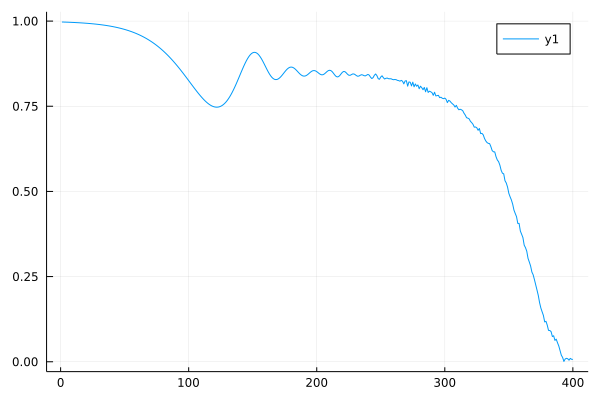

In [20]:
t_list = 10.0 .^(range(-1,stop=3,length=400))
Ainf = get_Ainf(8, 0.3, 1.0, 0.2, 0.9, t_list)
plot(Ainf)

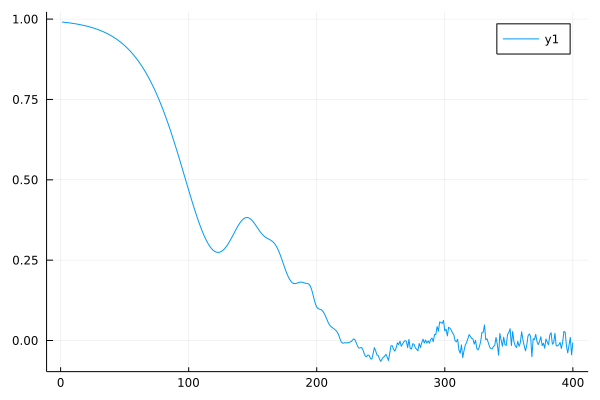

In [21]:
t_list = 10.0 .^(range(-1,stop=3,length=400))
Ainf = get_Ainf(8, 0.3, 1.0, 0.6, 0.9, t_list)
plot(Ainf)